# Jakarta Business Clustering

The main goal of this project is to explore and cluster the neighborhoods in Jakarta, Indonesia and also to determine the best location for various business placement. 

This idea comes from the process of business modeling which often require a strategic placement for their office or headquarter. It is very common for business contractor to do some analysis before setting up their business office in an area. 

So, which areas in Jakarta is most suitable for a specific kind of business? What are the factors affecting a strategic usiness placement? 

The target audience for this project are: 
- Potential constructor who wants to start their own business and need a recommendation for setting up their office in Jakarta
- Existing company who wants to renew their place in a different area of neighborhoods in Jakarta
- Anyone who is interested in neighborhood clustering using Python as a data science tools


**Dionisius Darryl Hermansyah**<br>
https://github.com/dionisiusdh/jakarta-business-clustering

---

### Importing Required Libraries

In [88]:
"""
Library requirements:
- BeautifulSoup
- Requests
- Pandas
- Numpy
- Matplotlib
- Geopy
- Folium
- Sklearn
"""

from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim

import folium 
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

### Setting up viewability

In [4]:
pd.set_option('max_colwidth', 800)

### Scraping the wikipedia website

In [7]:
url = 'https://en.wikipedia.org/wiki/List_of_districts_of_Jakarta'
res = requests.get(url).text 
soup = BeautifulSoup(res, 'html.parser')

### Getting the neighborhood name

In [49]:
lis = soup.find_all('li')
lis = lis[5:51] # Removing the redundant elements

In [61]:
neighborhoods = []
districts = []

for li in lis:
    li = li.get_text() # Getting the text from <li> elements
    neighborhoods.append(li)

In [66]:
for neighborhood in neighborhoods:
    if 'Jakarta' in neighborhood:
        districts.append(neighborhood)
        neighborhoods.remove(neighborhood)

neighborhoods[:5]

['Cengkareng', 'Grogol Petamburan', 'Kalideres', 'Kebon Jeruk', 'Kembangan']

### Making a dataframe from scraped-data

In [86]:
df = pd.DataFrame(neighborhoods)
df.columns = ['Neighborhood']

print(df.shape)
df.head()

(41, 1)


,Neighborhood
0,Cengkareng
1,Grogol Petamburan
2,Kalideres
3,Kebon Jeruk
4,Kembangan


### Using GeoPy to get the neighborhood's coordinates

In [80]:
geolocator = Nominatim(user_agent="jakarta_explore")
latitudes = []
longitudes = []

for neighborhood in df['Neighborhood']:
    location = geolocator.geocode(neighborhood)
    latitudes.append(location.latitude)
    longitudes.append(location.longitude)

### Adding the coordinates to the dataframe

In [87]:
df['Longitude'] = longitudes
df['Latitude'] = latitudes
df.head()

,Neighborhood,Longitude,Latitude
0,Cengkareng,106.744718,-6.152899
1,Grogol Petamburan,106.788317,-6.164188
2,Kalideres,106.701594,-6.137006
3,Kebon Jeruk,106.769725,-6.192572
4,Kembangan,106.740586,-6.191395


### Creating folium map with neighborhood markers

In [93]:
# Jakarta latitude and longitude
jkt_lat = -6.200000
jkt_long = 106.816666

# Create the map of Jakarta
map_jakarta = folium.Map(location=[jkt_lat, jkt_long], zoom_start=11)

# Add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_jakarta)  
    
map_jakarta

### Using FourSquare API to explore the neighborhoods

In [105]:
CLIENT_ID = 'your-foursquare-id' # replace with your Foursquare ID
CLIENT_SECRET = 'your-foursquare-secret' # replace with your Foursquare Secret
VERSION = '20200605'

In [99]:
LIMIT = 100
radius = 500

venues = []

for neighborhood, lat, long in zip(df['Neighborhood'], df['Latitude'], df['Longitude']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()['response']['groups'][0]['items']
    
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

### Converting the venues into a dataframe

In [119]:
venues_df = pd.DataFrame(venues)
venues_df.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Name', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
print(venues_df.shape)
venues_df.head()

(683, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Cengkareng,-6.152899,106.744718,Starbucks,-6.155363,106.747471,Coffee Shop
1,Cengkareng,-6.152899,106.744718,Nasi Goreng Mas Kis,-6.151866,106.748226,Food Truck
2,Cengkareng,-6.152899,106.744718,Roti Bakar Bandung,-6.152246,106.748035,Sandwich Place
3,Cengkareng,-6.152899,106.744718,Takoyaki Miyatako Citraland,-6.154955,106.748164,Japanese Restaurant
4,Cengkareng,-6.152899,106.744718,Rumah Makan 73 Ko Asun,-6.149321,106.747301,Chinese Restaurant


### One-hot encoding to analyze neighborhoods

In [154]:
# One hot encoding
jakarta_onehot = pd.get_dummies(venues_df[['Venue Category']], prefix="", prefix_sep="")

# Completing the dataframe
jakarta_onehot['Neighborhood'] = venues_df['Neighborhood'] 

# Moving neighborhood column to the first column
fixed_columns = list(jakarta_onehot.columns[96:]) + list(jakarta_onehot.columns[:96])
jakarta_onehot = jakarta_onehot[fixed_columns]

print(jakarta_onehot.shape)
jakarta_onehot.head()

(683, 142)


,Neighborhood,Nightclub,Noodle House,Office,Optical Shop,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,...,Massage Studio,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Motorcycle Shop,Multiplex,Music School,Music Venue
0,Cengkareng,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Cengkareng,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Cengkareng,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Cengkareng,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cengkareng,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Aggregating venues by neighborhoods

In [157]:
jakarta_grouped = jakarta_onehot.groupby('Neighborhood').mean().reset_index()
jakarta_grouped.head()

,Neighborhood,Nightclub,Noodle House,Office,Optical Shop,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,...,Massage Studio,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Motorcycle Shop,Multiplex,Music School,Music Venue
0,Cakung,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,Cempaka Putih,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,Cengkareng,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,Cilandak,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.012987,0.0,0.0,0.012987,0.0,0.0,0.0,0.0,0.0,0.0
4,Cilincing,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### Finding top 10 venues

In [303]:
# Function to return the most commong venues

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [304]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighborhood'] = jakarta_grouped['Neighborhood']

for ind in np.arange(jakarta_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(jakarta_grouped.iloc[ind, :], num_top_venues)
    
neighbourhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Cakung,Gas Station,Food,Lounge,Women's Store,American Restaurant,Airport Terminal,Acehnese Restaurant,Accessories Store,Yoga Studio,Wine Bar
1,Cempaka Putih,Pizza Place,Bakery,Acehnese Restaurant,BBQ Joint,Pool,Indonesian Meatball Place,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
2,Cengkareng,Coffee Shop,Japanese Restaurant,Sandwich Place,Food Truck,Chinese Restaurant,Women's Store,American Restaurant,Airport Terminal,Acehnese Restaurant,Accessories Store
3,Cilandak,Coffee Shop,Asian Restaurant,Indonesian Restaurant,Café,Bakery,Chinese Restaurant,Bookstore,Food Truck,Fast Food Restaurant,Ice Cream Shop
4,Cilincing,Park,Shopping Mall,Music Venue,Yoga Studio,Arcade,American Restaurant,Airport Terminal,Acehnese Restaurant,Accessories Store,Women's Store


### Neighborhood clustering using K-Means

In [305]:
jakarta_clustering = jakarta_grouped.drop('Neighborhood', axis = 1)

In [306]:
max_range = 20 # Maximum range of clusters

In [307]:
from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(3, max_range) :
    
    # Run k-means clustering
    jc = jakarta_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(jc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(jc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

### Plotting the scoring result

In [311]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(3, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

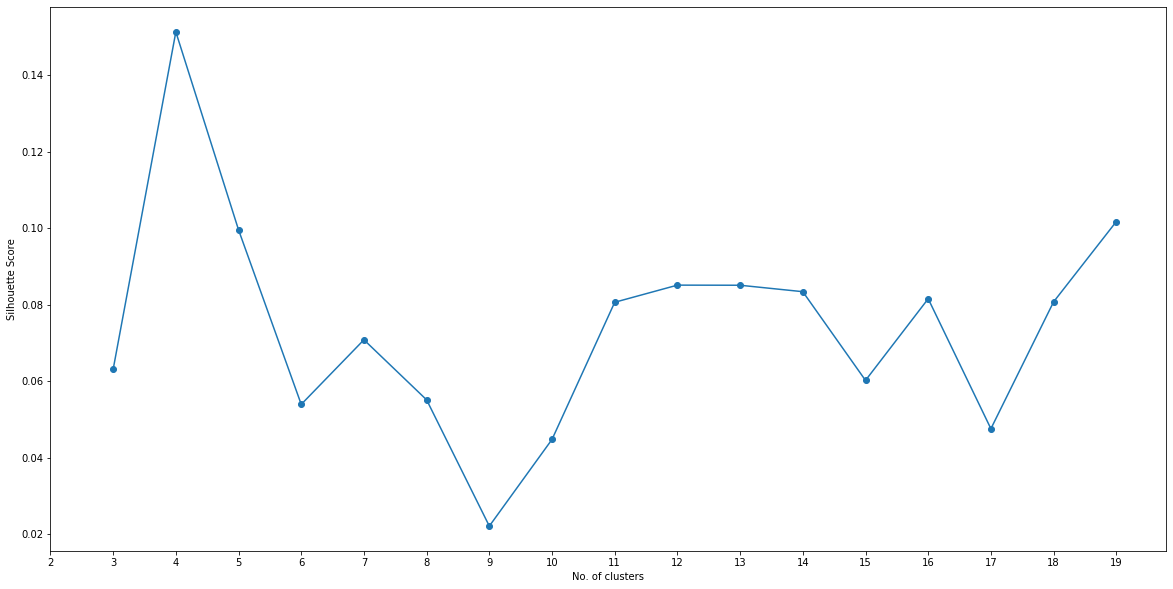

In [312]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [313]:
opt = np.argmax(scores) + 2 # Finds the optimal value
opt

3

### Clustering with optimal number of clusters

In [314]:
kclusters = opt

# Run k-means clustering
jc = jakarta_clustering
kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit(jc)

In [315]:
# Add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [316]:
neighbourhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Cakung,Gas Station,Food,Lounge,Women's Store,American Restaurant,Airport Terminal,Acehnese Restaurant,Accessories Store,Yoga Studio,Wine Bar
1,0,Cempaka Putih,Pizza Place,Bakery,Acehnese Restaurant,BBQ Joint,Pool,Indonesian Meatball Place,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
2,0,Cengkareng,Coffee Shop,Japanese Restaurant,Sandwich Place,Food Truck,Chinese Restaurant,Women's Store,American Restaurant,Airport Terminal,Acehnese Restaurant,Accessories Store
3,0,Cilandak,Coffee Shop,Asian Restaurant,Indonesian Restaurant,Café,Bakery,Chinese Restaurant,Bookstore,Food Truck,Fast Food Restaurant,Ice Cream Shop
4,0,Cilincing,Park,Shopping Mall,Music Venue,Yoga Studio,Arcade,American Restaurant,Airport Terminal,Acehnese Restaurant,Accessories Store,Women's Store


### Creating final dataframe

In [317]:
jakarta_final = df
jakarta_final = jakarta_final.join(neighbourhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
jakarta_final.dropna(inplace = True)
jakarta_final['Cluster Labels'] = jakarta_final['Cluster Labels'].astype(int)
jakarta_final.head()

,Neighborhood,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Cengkareng,106.744718,-6.152899,0,Coffee Shop,Japanese Restaurant,Sandwich Place,Food Truck,Chinese Restaurant,Women's Store,American Restaurant,Airport Terminal,Acehnese Restaurant,Accessories Store
1,Grogol Petamburan,106.788317,-6.164188,0,Chinese Restaurant,Noodle House,Asian Restaurant,Indonesian Restaurant,Hotel,Pizza Place,Fast Food Restaurant,Coffee Shop,Seafood Restaurant,Hospital
2,Kalideres,106.701594,-6.137006,1,Indonesian Restaurant,Bookstore,Optical Shop,Fried Chicken Joint,Food Truck,Convenience Store,Women's Store,American Restaurant,Airport Terminal,Acehnese Restaurant
3,Kebon Jeruk,106.769725,-6.192572,1,Noodle House,Asian Restaurant,Indonesian Restaurant,Concert Hall,Convenience Store,Café,Art Museum,Ice Cream Shop,Coffee Shop,Juice Bar
4,Kembangan,106.740586,-6.191395,0,Asian Restaurant,Chinese Restaurant,Japanese Restaurant,Coffee Shop,Café,Food Court,Clothing Store,Pizza Place,Seafood Restaurant,Gym / Fitness Center


### Cluster Visualization

In [318]:
# Create map
map_clusters = folium.Map(location=[jkt_lat, jkt_long], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(jakarta_final['Latitude'], jakarta_final['Longitude'], jakarta_final['Neighborhood'], jakarta_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' (Cluster ' + str(cluster + 1) + ')', parse_html=True)
    map_clusters.add_child(
        folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7))
       
map_clusters

### Examining the clusters

In [319]:
clusters = pd.DataFrame(jakarta_final.groupby('Cluster Labels', as_index=False).apply(lambda x: ", ".join(x['Neighborhood'].tolist())), columns=['Similar'])
clusters['Count'] = jakarta_final.groupby('Cluster Labels')['Neighborhood'].count()

print("Cluster | Count | Neighbourhoods")
print("--------|-------|---------------")
for x,y,z in zip(clusters.index,clusters['Count'],clusters['Similar']):
    print("{} | {} | {}".format(x,y,z))

Cluster | Count | Neighbourhoods
--------|-------|---------------
0 | 24 | Cengkareng, Grogol Petamburan, Kembangan, Palmerah, Taman Sari, Tambora, Cempaka Putih, Kemayoran, Cilandak, Jagakarsa, Kebayoran Baru, Kebayoran Lama, Pasar Minggu, Setiabudi, Cakung, Duren Sawit, Jatinegara, Kramat Jati, Matraman, Menteng, Cilincing, Kelapa Gading, Pademangan, Penjaringan
1 | 12 | Kalideres, Kebon Jeruk, Johar Baru, Sawah Besar, Senen, Mampang Prapatan, Pancoran, Tebet, Ciracas, Makasar, Pasar Rebo, Pulo Gadung
2 | 2 | Pesanggrahan, Koja


In [320]:
jakarta_final.head()

,Neighborhood,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Cengkareng,106.744718,-6.152899,0,Coffee Shop,Japanese Restaurant,Sandwich Place,Food Truck,Chinese Restaurant,Women's Store,American Restaurant,Airport Terminal,Acehnese Restaurant,Accessories Store
1,Grogol Petamburan,106.788317,-6.164188,0,Chinese Restaurant,Noodle House,Asian Restaurant,Indonesian Restaurant,Hotel,Pizza Place,Fast Food Restaurant,Coffee Shop,Seafood Restaurant,Hospital
2,Kalideres,106.701594,-6.137006,1,Indonesian Restaurant,Bookstore,Optical Shop,Fried Chicken Joint,Food Truck,Convenience Store,Women's Store,American Restaurant,Airport Terminal,Acehnese Restaurant
3,Kebon Jeruk,106.769725,-6.192572,1,Noodle House,Asian Restaurant,Indonesian Restaurant,Concert Hall,Convenience Store,Café,Art Museum,Ice Cream Shop,Coffee Shop,Juice Bar
4,Kembangan,106.740586,-6.191395,0,Asian Restaurant,Chinese Restaurant,Japanese Restaurant,Coffee Shop,Café,Food Court,Clothing Store,Pizza Place,Seafood Restaurant,Gym / Fitness Center


In [329]:
clusters_grouped = jakarta_final.groupby(['Cluster Labels','1st Most Common Venue']).count().reset_index()
clusters_grouped[['Cluster Labels', '1st Most Common Venue']]

,Cluster Labels,1st Most Common Venue
0,0,Arcade
1,0,Art Gallery
2,0,Asian Restaurant
3,0,Bakery
4,0,Bar
5,0,Chinese Restaurant
6,0,Coffee Shop
7,0,Food Truck
8,0,Gas Station
9,0,Hotel
